In [1]:
import pandas as pd
import numpy as np
import csv
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/Users/Soren.Johansenc3.ai/.local/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/envs/odeNeural/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Soren.Johansenc3.ai/.local/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/opt/anaconda3/envs/odeNeural/lib/python3.8/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/Soren.Johansenc3.ai/.local/lib/python3.8/site-packages/matplotlib/__init__.py:152: Deprecatio

# Content:
## Import and join dataframes
## Top selling Products
## Purchases over time
## Correlation
## Complexity of Apriori method
## Aprori Analysis

All the calculations is defined as a function. 

## Import data and join dataframes

In [2]:
df_cust=pd.read_csv('./data/customers.csv')

In [3]:
df_cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [4]:
df_articles=pd.read_csv('./data/articles.csv')

In [5]:
df_articles.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [6]:
df_articles.prod_name.unique().shape

(45875,)

In [7]:
df_articles.index_group_name.unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [8]:
df_articles.product_type_name.unique().shape

(131,)

In [9]:
df_trans=pd.read_csv('./data/transactions_train.csv')

In [10]:
df_trans.shape

(31788324, 5)

In [11]:
df_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [12]:
df_trans['t_dat'] = pd.to_datetime(df_trans['t_dat'])

In [13]:
df_trans.t_dat.min()

Timestamp('2018-09-20 00:00:00')

In [14]:
df_trans.t_dat.max()

Timestamp('2020-09-22 00:00:00')

Time span in days

In [15]:
spandays=(df_trans.t_dat.max()-df_trans.t_dat.min())

In [16]:
print('Span in Years',spandays / np.timedelta64(1, 'Y'))

Span in Years 2.006885836122576


On transaction data frame join the articles data frame

In [17]:
newdf=df_trans.merge(df_articles,on='article_id', how='left')

In [18]:
newdf.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."


And finaly join the customer data frame to dataframe

In [19]:
newdf=newdf.merge(df_cust,on='customer_id', how='left')

In [20]:
#product categories 
newdf.product_group_name.unique()

array(['Underwear', 'Garment Upper body', 'Garment Lower body',
       'Accessories', 'Socks & Tights', 'Shoes', 'Garment Full body',
       'Nightwear', 'Swimwear', 'Underwear/nightwear', 'Cosmetic',
       'Unknown', 'Items', 'Bags', 'Interior textile', 'Furniture',
       'Garment and Shoe care', 'Stationery', 'Fun'], dtype=object)

The data frame is final 'joined' dataframe.


The variable 'index_group_name' can be a proxy for sex.

In [21]:
newdf.index_group_name.value_counts()

Ladieswear       20415260
Divided           7138254
Menswear          1771053
Sport             1246408
Baby/Children     1217349
Name: index_group_name, dtype: int64

Add agegroup variable to the dataframe derived from the age. 

In [22]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
#labels = ['Teen','Young Adult', 'Adult']
newdf['AgeGroup'] = pd.cut(newdf['age'], bins=bins, right=True)


In [23]:

ag = newdf.groupby('index_group_name').AgeGroup.value_counts().sort_index()

In [24]:
ag.unstack()

AgeGroup,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]"
index_group_name,,,,,,,,,,
Baby/Children,0,20698,213336,378524,432052,124946,31381,5490,397,9
Divided,0,499284,3302778,1089523,1119271,907514,163792,24494,2043,254
Ladieswear,0,839648,8716621,3657362,3132015,3122457,727597,124593,7909,847
Menswear,0,70808,666335,264962,334316,353188,64148,8304,518,63
Sport,0,41715,562056,238828,197483,171928,25804,2552,174,49


Final dimensions of the data file 

In [25]:
newdf.shape

(31788324, 36)

In [26]:
#newdf.dtypes

In [27]:
len(newdf.prod_name.unique())

45508

# Top Selling products

The most top ranking purchased products 

In [28]:
topprod=newdf.product_type_name.value_counts()

In [29]:
topprod.head(10)

Trousers      4217017
Dress         3238428
Sweater       2783274
T-shirt       2203750
Top           1583408
Blouse        1504868
Vest top      1414101
Bra           1335233
Shorts        1152513
Bikini top    1126202
Name: product_type_name, dtype: int64

In [30]:


def topselling(top):
    dftop = topprod.head(top)
    return dftop.plot.bar(dftop,title='Top selling products')

#fig = go.Figure(data=[go.Histogram(y=y)])
#fig.show()

<AxesSubplot:title={'center':'Top selling products'}>

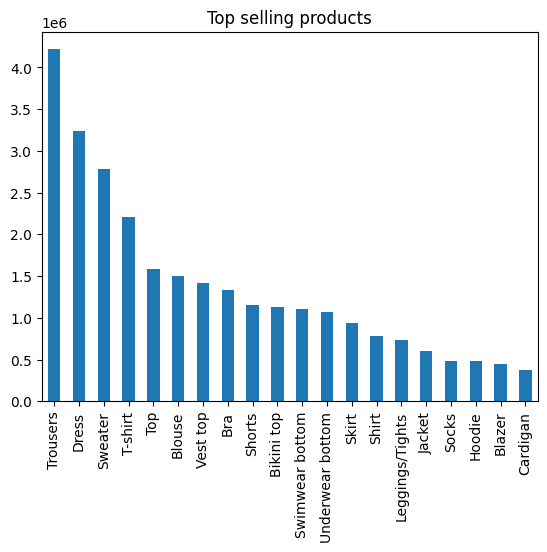

In [31]:
topselling(20)

# Purchases over Time

In [34]:
def product_time(prod='Trousers'):
    mask=newdf.product_type_name==prod
    prod_time=newdf[mask]
    df1 = prod_time.groupby(prod_time['t_dat']).size().reset_index(name='Count')
    return sns.scatterplot(data=df1, x="t_dat", y="Count").set_title('Number of Purchases of Product over time span')

Text(0.5, 1.0, 'Number of Purchases of Product over time span')

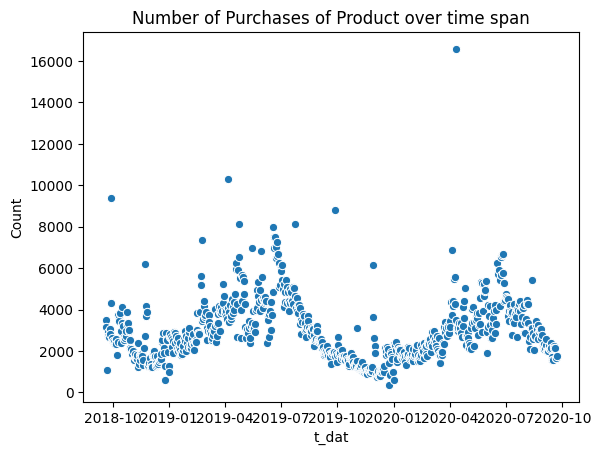

In [35]:
# T-shirt and Swimsuit Jacket Shorts
product_time('T-shirt')

# Correlation

In [36]:
def prod_corr(topXprods=10):
    topprod=newdf.product_type_name.value_counts()
    list_topX=topprod.head(topXprods)
    t=newdf[newdf.product_type_name.isin(list_topX.index)]
    t_new=t[['t_dat','product_type_name']]
    y=t_new.groupby(['t_dat','product_type_name']).size().reset_index(name='Count')
    y_new=y.pivot_table(columns=['product_type_name'],index='t_dat', values='Count')
    #fig = px.imshow(y_new.corr(),title='Correlation Between Products')
    ax = plt.axes()
    ax.set_title('Correlation Between Products')
    return sns.heatmap(y_new.corr())

<AxesSubplot:title={'center':'Correlation Between Products'}, xlabel='product_type_name', ylabel='product_type_name'>

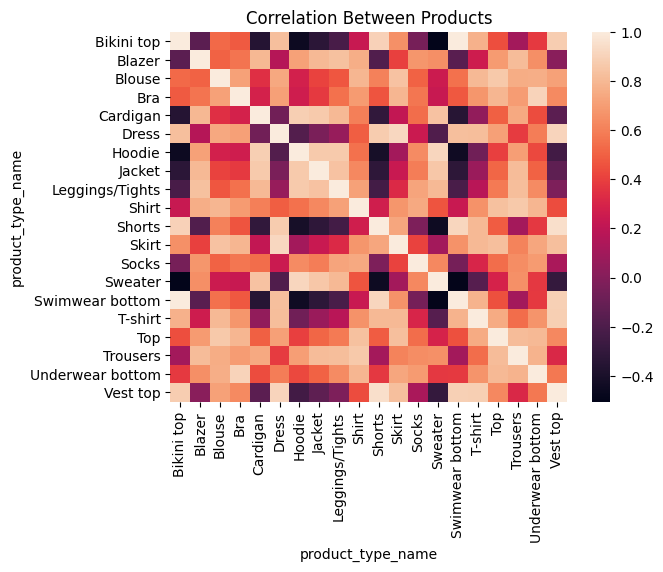

In [37]:
prod_corr(20)

# Complexity of Apriori Method

On page 215 and 216 in the textbook it is shown how we can calculate the memory requirement.
The number of rows in purchases_list is :

$$len(purchases\_list)=9.080.179 \hspace{0.5cm} baskets $$

We can calculate the number of unique items in our dataset:

$$ len(testnew.prod\_name.unique())=5.424.262 $$

Note testnew is my input to purchases_list so it must be same number items in purchases_list.

The number of pairs as:

$$\binom{5.424.262}{ 2}$$

This is approximately 

$$\frac{5.424.262^2}{2}=  1,47E+13 \hspace{0.5cm } store\hspace{0.1cm} space. $$

If integers take 4 bytes then it requires $2 \cdot items^2$ bytes.

This gives $2\cdot 5.424.262^2=5,88E+13$ bytes and equivalent to 58.845 Gigabytes. This figure should then be multiplied by number of baskets. 

The big O complexity of the Apriori method is $O(2^D)$ - which is exponential. 

# Aprori Analysis

Only use variables t_dat, customer_id, prod_name and age. For use in aprori analysis below.

In [36]:
select_newdf=newdf[['t_dat','customer_id','prod_name','age']]

In [37]:
select_newdf.head(10)

,t_dat,customer_id,prod_name,age
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Atlanta Push Body Harlow,24.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Rae Push (Melbourne) 2p,24.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,Inca Jumper,32.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,W YODA KNIT OL OFFER,32.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,W YODA KNIT OL OFFER,32.0
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,W YODA KNIT OL OFFER,32.0
6,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,Inca jumper,32.0
7,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,Gyda!,29.0
8,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,Thomas paperbag wide,29.0
9,2018-09-20,00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...,Fiona Wide,29.0


In [38]:
test = select_newdf.groupby(['customer_id', 't_dat','age'])['prod_name'].apply(lambda x: ','.join(x.astype(str))).reset_index() 

In [39]:
testnew=pd.DataFrame(test)

In [40]:
testnew.head()

,customer_id,t_dat,age,prod_name
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2018-12-27,49.0,"BB Chris puff jkt TP,Mr Harrington w/hood,FLOR..."
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-05-02,49.0,Sophie jumpsuit
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-05-25,49.0,"Mariette Blazer,Mariette Blazer"
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-07-25,49.0,"The Firm (1),Skirt Mini Stretch Edie"
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-09-18,49.0,Serpente HW slim trouser


In [41]:
len(testnew)

9033718

In [42]:
age20_30=testnew[(testnew.age>=20) & (testnew.age<=30)]

In [120]:
age30_40=testnew[(testnew.age>=30) & (testnew.age<=40)]

In [43]:
age20_30.head()

,customer_id,t_dat,age,prod_name
10,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2018-09-21,25.0,"Noel denim dress,Portofino ISW 28,CORY CORD SKIRT"
11,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2018-09-25,25.0,"Sirpa mockneck,Janet sweater"
12,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2018-09-27,25.0,"Noel denim dress,Henry polo. (1)"
13,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2018-09-29,25.0,Janet sweater
14,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-01-10,25.0,Thelma poloneck


Number of customers betweeen age 20-30:

In [44]:
len(age20_30)

4019286

In [45]:
#Function to sample frac% of customers

def sample_cust(data, frac):
    b=data.customer_id.sample(frac=frac)
    return data.loc[b.index]

In [80]:
o=sample_cust(age20_30,0.03)

In [121]:
o30_40=sample_cust(age30_40,0.03)

In [122]:
len(o30_40)

49883

This is the number of unique customers: 

In [81]:
len(o)

120579

This is the number of unique items in the frac% customer sample:

In [82]:
len(o.prod_name.unique())

91743

In [126]:
# Only the basket
#prods=o['prod_name']
prods=o30_40['prod_name']

In [127]:
art=prods.values.tolist()


In [128]:
art[0]

'Freddy,Fleece trs (J),Monaco'

The same function as Hannah

In [129]:
purchases_list = [] 

for i in art:
    #print(i)
    purchases_list.append(i.split(",")) 
        

In [87]:
#count=[]
#for j in range(len(purchases_list)):
#    count.append(len(purchases_list[j]))

In [88]:
#Export the purchases_list to csv file

fields = ['BasketNew']
with open('o', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(purchases_list)

In [130]:
#Sparse=True go in fit 
te = TransactionEncoder()
te_ary = te.fit(purchases_list).transform(purchases_list)
df = pd.DataFrame(te_ary,columns=te.columns_)


In [131]:
df.head()


,& Denim Boyfriend LW denim,&DENIM Bootcut RW Speed,&DENIM Bootcut RW soho,&DENIM Boyfriend LW,&DENIM Embrace denim shorts,&DENIM Girlfriend,&DENIM Girlfriend RW,&DENIM Girlfriend TR,&DENIM Jacket Daisy Garden,&DENIM Jacket black jewel,...,victoria body,vivi velvet top,waikiki straw hat,wheeler jumpsuit,wheeler jumpsuit (1),whisper shorts,windu cardigan,wow item BFF swettis,x-ray,zelda leggings
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The above dimsions have really confused me !!!! The rows does not fit....But look below.

In [132]:
df.shape

(49883, 24237)

In [108]:
def aprio(df,minsup=0.001):
    apo=apriori(df, min_support=minsup, use_colnames=True)
    apo['length'] = apo['itemsets'].apply(lambda x: len(x))
    apo=apo.sort_values(by=['support'],ascending=False)
    return apo

In [109]:
# Age 20-30

aprio(df,0.001)

,support,itemsets,length
166,0.016222,(Jade HW Skinny Denim TRS),1
381,0.010632,(Timeless Midrise Brief),1
222,0.010159,(Luna skinny RW),1
376,0.008268,(Tilly (1)),1
67,0.008003,(Cat Tee.),1
...,...,...,...
232,0.001012,(Maria Shorts.),1
242,0.001012,(Milk),1
275,0.001012,(Papi Chulo Top),1
292,0.001003,(R-NECK SS SLIM FIT),1


In [110]:
#age 20-30
apo[apo.length>=2]

,support,itemsets,length
422,0.003641,"(Simple as that Cheeky Tanga, Simple as That T...",2
421,0.002422,"(Shake it in Balconette, Timeless Midrise Brief)",2
423,0.001990,"(Timeless Midrise Brief, Simple as That Triang...",2
424,0.001443,"(Timeless Sports Top, The Low Line Highwaist)",2
420,0.001153,"(Timeless Midrise Brief, New Girl Push Top)",2
419,0.001128,"(New Girl Wide Side Tanga, New Girl Push Top)",2
425,0.001020,"(Timeless Midrise Brief, Timeless Triangle Top)",2
418,0.001012,"(Lazer Razer Brief, Lazer Razer Adj. push tria...",2


In [112]:
def freqitm(df,minsup=0.001):
    frequent_itemsets = fpgrowth(df, min_support=minsup,use_colnames=True)
    frequent_itemsets.sort_values(by=['support'],ascending=False)
    return frequent_itemsets

In [114]:
# age 20-30
# the same as above but faster 
freqitm(df,0.001)

,support,itemsets
0,0.001252,(Claudine rib t-shirt)
1,0.001161,(1pk Fun)
2,0.016222,(Jade HW Skinny Denim TRS)
3,0.004445,(Julia RW Skinny Denim TRS)
4,0.001252,(Siri Cardigan)
...,...,...
421,0.002422,"(Shake it in Balconette, Timeless Midrise Brief)"
422,0.001153,"(Timeless Midrise Brief, New Girl Push Top)"
423,0.001128,"(New Girl Wide Side Tanga, New Girl Push Top)"
424,0.001012,"(Lazer Razer Brief, Lazer Razer Adj. push tria..."


In [115]:
def apo_rules(frequent_itemsets):
    apriori_rules=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.0002)
    apriori_rules=apriori_rules.sort_values('confidence', ascending = False, inplace = True)
    return apriori_rules

In [117]:
apo_rules(frequent_itemsets)

In [118]:
#Age 20-30
apriori_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(The Low Line Highwaist),(Timeless Sports Top),0.001957,0.002214,0.001443,0.737288,332.964293,0.001439,3.798023
10,(New Girl Wide Side Tanga),(New Girl Push Top),0.001650,0.004495,0.001128,0.683417,152.040127,0.001120,3.144532
14,(Timeless Sports Top),(The Low Line Highwaist),0.002214,0.001957,0.001443,0.651685,332.964293,0.001439,2.865349
13,(Lazer Razer Adj. push triangle),(Lazer Razer Brief),0.001717,0.004644,0.001012,0.589372,126.903364,0.001004,2.423984
0,(Simple as that Cheeky Tanga),(Simple as That Triangle Top),0.006485,0.007605,0.003641,0.561381,73.817632,0.003591,2.262545
1,(Simple as That Triangle Top),(Simple as that Cheeky Tanga),0.007605,0.006485,0.003641,0.478735,73.817632,0.003591,1.905968
6,(Shake it in Balconette),(Timeless Midrise Brief),0.005689,0.010632,0.002422,0.425656,40.035236,0.002361,1.722605
3,(Timeless Triangle Top),(Timeless Midrise Brief),0.002986,0.010632,0.001020,0.341667,32.135589,0.000988,1.502837
5,(Simple as That Triangle Top),(Timeless Midrise Brief),0.007605,0.010632,0.001990,0.261723,24.616458,0.001910,1.340104
9,(New Girl Push Top),(Timeless Midrise Brief),0.004495,0.010632,0.001153,0.256458,24.121214,0.001105,1.330614


In [ ]:
#age 30-40

In [133]:
aprio(df,0.001)

,support,itemsets,length
243,0.013071,(Luna skinny RW),1
397,0.009502,(Tilly (1)),1
401,0.009402,(Timeless Midrise Brief),1
185,0.009242,(Jade HW Skinny Denim TRS),1
345,0.008079,(Shake it in Balconette),1
...,...,...,...
31,0.001002,(Barton midi skirt),1
151,0.001002,(Grimsby),1
311,0.001002,(Prima(1)),1
149,0.001002,(Greta ctn brazilian 3p),1


In [134]:
#age 30-40
freqitm(df,0.001)

,support,itemsets
0,0.002105,(Jennifer (1))
1,0.001784,(Support 40 den 1p Tights)
2,0.001463,(40 den 2p Tights)
3,0.001062,(Control Lt 40 den 2p Tights)
4,0.001042,(Kia Paperbag (1))
...,...,...
431,0.001463,(Pingu top)
432,0.002546,"(Simple as that Cheeky Tanga, Simple as That T..."
433,0.001203,"(Timeless Midrise Brief, New Girl Push Top)"
434,0.003147,"(Shake it in Balconette, Timeless Midrise Brief)"


In [135]:
apo_rules(frequent_itemsets)

In [138]:
#age30-40
apriori_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(The Low Line Highwaist),(Timeless Sports Top),0.001957,0.002214,0.001443,0.737288,332.964293,0.001439,3.798023
10,(New Girl Wide Side Tanga),(New Girl Push Top),0.001650,0.004495,0.001128,0.683417,152.040127,0.001120,3.144532
14,(Timeless Sports Top),(The Low Line Highwaist),0.002214,0.001957,0.001443,0.651685,332.964293,0.001439,2.865349
13,(Lazer Razer Adj. push triangle),(Lazer Razer Brief),0.001717,0.004644,0.001012,0.589372,126.903364,0.001004,2.423984
0,(Simple as that Cheeky Tanga),(Simple as That Triangle Top),0.006485,0.007605,0.003641,0.561381,73.817632,0.003591,2.262545
1,(Simple as That Triangle Top),(Simple as that Cheeky Tanga),0.007605,0.006485,0.003641,0.478735,73.817632,0.003591,1.905968
6,(Shake it in Balconette),(Timeless Midrise Brief),0.005689,0.010632,0.002422,0.425656,40.035236,0.002361,1.722605
3,(Timeless Triangle Top),(Timeless Midrise Brief),0.002986,0.010632,0.001020,0.341667,32.135589,0.000988,1.502837
5,(Simple as That Triangle Top),(Timeless Midrise Brief),0.007605,0.010632,0.001990,0.261723,24.616458,0.001910,1.340104
9,(New Girl Push Top),(Timeless Midrise Brief),0.004495,0.010632,0.001153,0.256458,24.121214,0.001105,1.330614
